In [1]:
import numpy as np
import pandas as pd
from pyswmm_lite import Env
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {}
import pickle
from automate_objective import generate_targets, generate_weights
from utilities_baeopt import swmm_execute
import matplotlib.pyplot as plt
from GPyOpt.methods import BayesianOptimization
import requests
import os 
NODES_LIS = {'93-49743' : 'OR39',
             '93-49868' : 'OR34',
             '93-49919' : 'OR44',
             '93-49921' : 'OR45',
             '93-50074' : 'OR38',
             '93-50076' : 'OR46',
             '93-50077' : 'OR48',
             '93-50081' : 'OR47',
             '93-50225' : 'OR36',
             '93-90357' : 'OR43',
             '93-90358' : 'OR35'}
def performance_metric(data, ctrl_weights, threshold=5.0, verbose=False):
    """
    Computes performance metrics for the optimization 
    based on the threshold. 

    Parameters:
    --------------------------------------------------
    data: dict of pandas dataframes with outflows and flooding

    Returns:
    --------------------------------------------------
    performance_metric : pefromance of the objetive 
    """
    outflows = data["outflows"]
    flooding = data["flooding"]
    # Get the performance metric 
    perforamce  = 0.0
    # Check if there is flooding in the assets 
    flooding = flooding.gt(0.0)
    flooding = flooding.any()
    if flooding.any(): 
        if verbose:
            # TODO print the quantity of flooding
            print("Nodes with flooding: {}".format(flooding[flooding == True].index))
        perforamce += 10**8
    # Estimate the perfomance from the flows
    outflows = outflows.sub(threshold)
    outflows[outflows < 0.0] = 0.0
    outflows = outflows.sum()
    for i in outflows.keys():
        perforamce += outflows[i] * ctrl_weights[i]
    return perforamce
# Set the threshold
THRESHOLD = 5.0 
ctrl_elements = NODES_LIS.keys()
number_of_ctrl_elements = 11 
# Set up the objective function
data_uncontrolled = np.load("./uncontrolled_flow_AA.npy").item()
inflows_uncontrolled = data_uncontrolled["inflows"]
# Control weights 
ctrl_weights = generate_weights(inflows_uncontrolled)
def objective_function(x):
    # Run SWMM and get the trajectories 
    # Pick a random snapshot 
    i = np.random.choice(np.linspace(1, 20, 20, dtype=int), 1)
    data = swmm_execute(x, ctrl_elements, network="./raindata/"+str(i[0])+"runfile.inp")
    obj_value = performance_metric(data, ctrl_weights, THRESHOLD)
    return obj_value

# Create the domain
domain = []
for i in range(1, number_of_ctrl_elements+1):
    domain.append({'name': 'var_'+str(i), 'type': 'continuous', 'domain': (0.0, 1.0)})

In [4]:
# Identify the best solution for the saved bayesian optimization models 
temp_myBopt = BayesianOptimization(f=objective_function,
        domain=domain,
        model_type = 'GP',
        acquisition_type='EI')
f_open = open("./uncertain_network/Bayopt500", 'rb')
temp_myBopt.__dict__.update(pickle.load(f_open))
temp_myBopt._compute_results()

In [5]:
temp_myBopt.x_opt

array([0.54639564, 0.4846254 , 0.25197914, 0.19750169, 0.211112  ,
       0.30710038, 0.69903602, 0.70885236, 0.60058346, 0.25919893,
       0.75651624])

In [6]:
# Test the response of the ensemble. 
controlled_responses = {}
ensemble = np.linspace(1, 20, 20, dtype=int)
for i in ensemble:
    controlled_responses[str(i)] = swmm_execute(temp_myBopt.x_opt.reshape(1,number_of_ctrl_elements), ctrl_elements, network="./raindata/"+str(i)+"runfile.inp")

In [7]:
performance = []
for i in controlled_responses.keys():
    performance.append(performance_metric(controlled_responses[i], ctrl_weights))

In [8]:
mean = np.mean(performance)
var = np.var(performance)

<IPython.core.display.Javascript object>


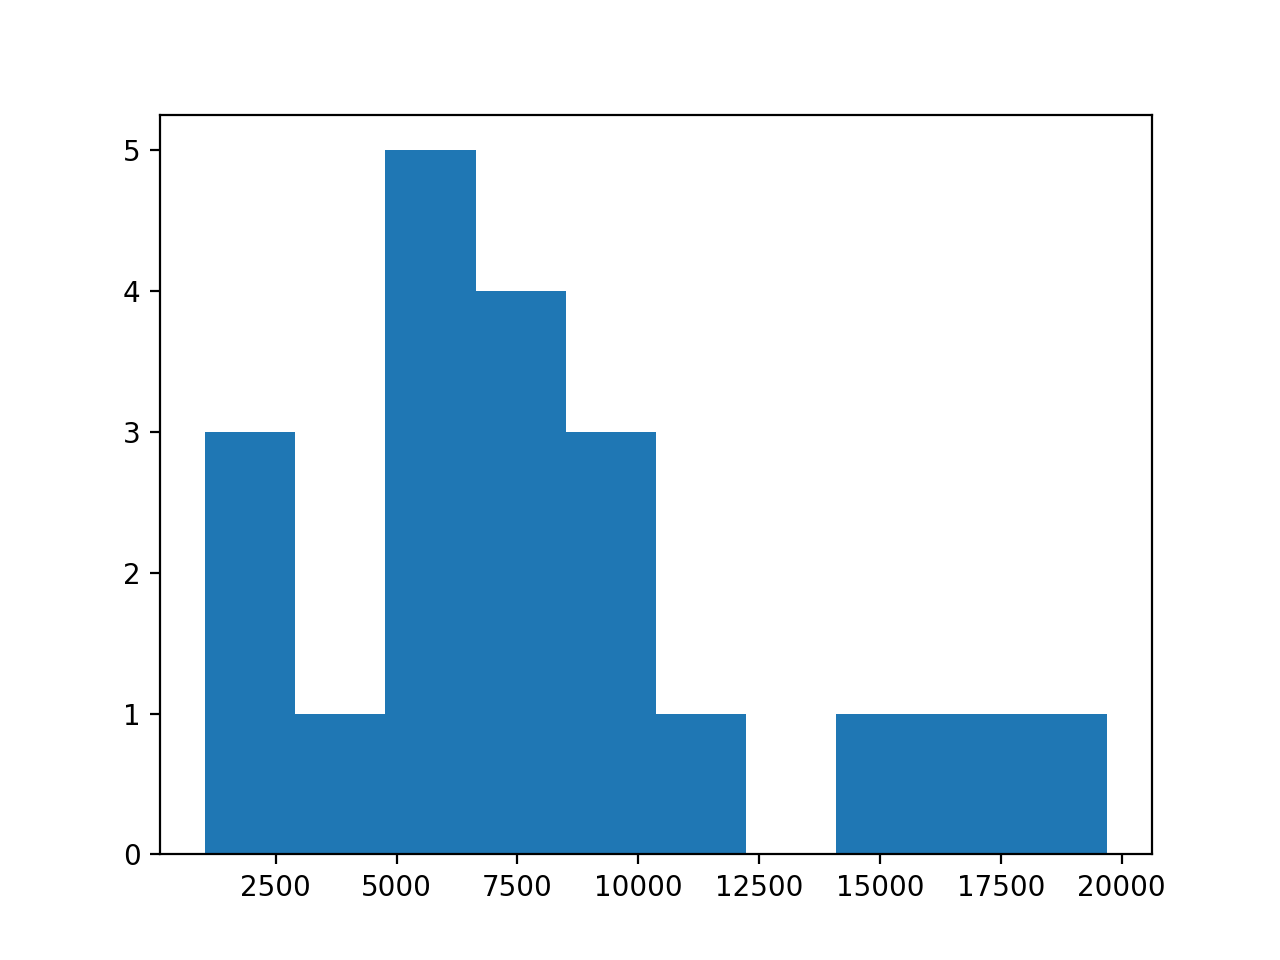

(array([3., 1., 5., 4., 3., 1., 0., 1., 1., 1.]),
 array([ 1038.78496688,  2904.30411716,  4769.82326744,  6635.34241772,
         8500.861568  , 10366.38071828, 12231.89986856, 14097.41901884,
        15962.93816913, 17828.45731941, 19693.97646969]),
 <a list of 10 Patch objects>)

In [9]:
plt.hist(performance)

In [32]:
np.mean(performance)

8131.751875458787

In [2]:
import seaborn as sns

<IPython.core.display.Javascript object>


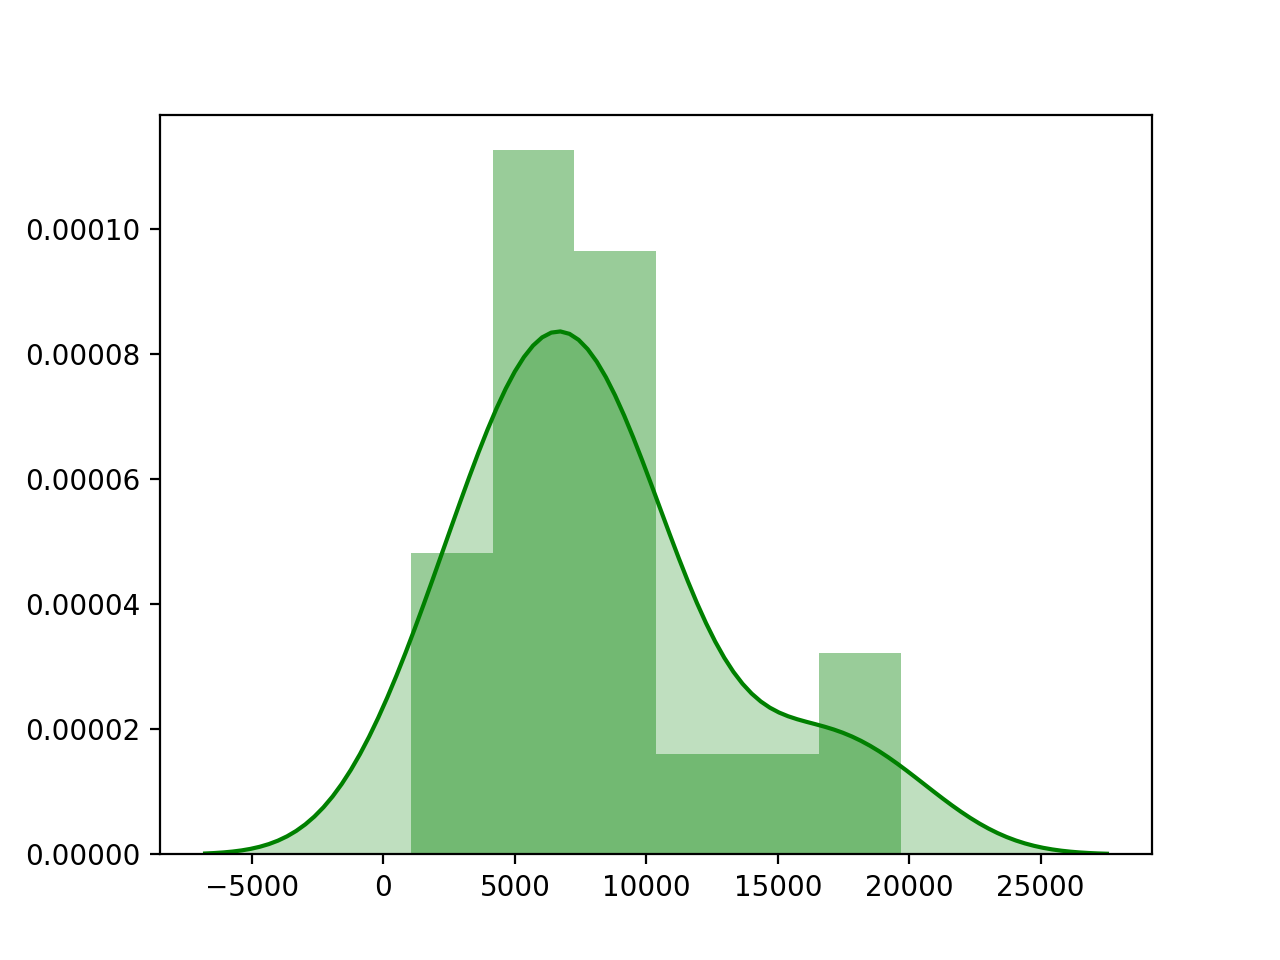

In [19]:
sns.distplot(performance, color="g", kde_kws={"shade": True})
plt.savefig("./network_uncertain.svg")

In [20]:
pwd

'/Users/abhiram/Research/BaeOpt'

In [3]:
import scipy.io as sio

In [6]:
rinf = sio.loadmat("./Atlas 14 m files/rainfall_input.mat")

In [7]:
rinf["rainfall"]

array([[3.31924235, 3.5363999 , 3.40980258, ..., 3.43975396, 3.49192883,
        3.23717666]])

<IPython.core.display.Javascript object>


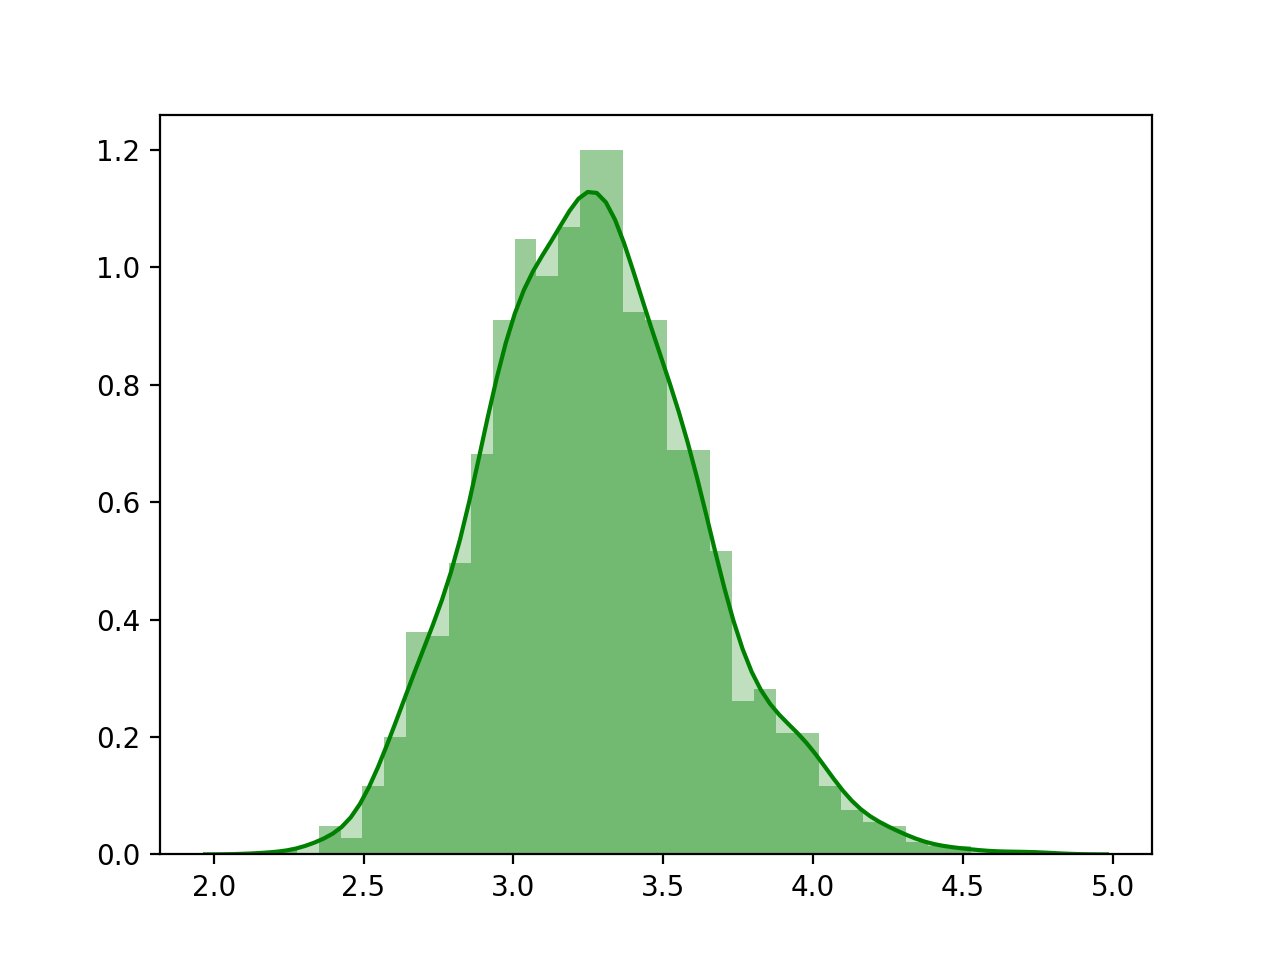

In [9]:
sns.distplot(rinf["rainfall"], color="g", kde_kws={"shade": True})
plt.savefig("./input_rainfall.svg")